In [90]:
import pandas as pd
import numpy as np
import pybaseball as pb
import math
import os
import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import shap
import seaborn as sns
import plotly.express as px
from pybaseball import cache
cache.enable()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [91]:
today = dt.date.today()

selected_stats = [
    'Name', 'G', 'AB', 'PA', 'H', '2B', '3B', 'HR', 'R',
    'RBI', 'SB', 'CS', 'BB%', 'K%', 'OBP', 'SLG', 'wOBA',
    'xwOBA', 'xBA', 'xSLG', 'Barrels', 'EV', 'LA', 'WAR',
    'key_mlbam'
]

In [92]:
def get_fg_stats(year, selected_stats=selected_stats):
    out = pb.fg_batting_data(year, qual=0)
    print(out.shape)
    id_table = pb.playerid_reverse_lookup(out['IDfg'], key_type='fangraphs')
    out = pd.merge(out, id_table, left_on='IDfg', right_on='key_fangraphs')

    return out[selected_stats]


In [93]:
def impute_missing_sprayangle(bbe, edge_cases=[39485]):
    """
    Imputes missing values in the "theta_deg" (spray angle) column of the batted ball events data frame.

    Parameters:
    bbe (pandas.DataFrame): The batted ball events data frame.
    edge_cases (list): A list of mlbam ids for players whose missing values should be imputed with special logic.

    Returns:
    bbe (pandas.DataFrame): The batted ball events data frame with missing values in the "theta_deg" column imputed.
    """

    ## Print summary statistics of spray angle column
    print(bbe['theta_deg'].describe())
    
    ## Calculate mean spray angle by batter stance (left or right)
    splits = bbe.groupby('stand')['theta_deg'].mean().round()
    
    ## Impute missing spray angles for home runs hit to pulled side
    pull_hr_index = bbe.loc[(bbe['hc_x'].isna())&(bbe['events']=='home_run')].index.tolist()
    print(pull_hr_index)
    for player in edge_cases:
        if player in pull_hr_index:
            pull_hr_index.remove(player)

    bbe.loc[pull_hr_index, 'theta_deg'] = 0
    bbe.loc[pull_hr_index, 'theta_deg'] = bbe.loc[pull_hr_index, 'theta_deg'].where((bbe['stand']=='L'), 90)
    bbe.loc[pull_hr_index].head(3)

    ## Impute missing spray angles for all other batted ball events
    other_missing = bbe.loc[(bbe['hc_x'].isna()) & (bbe['events']!='home_run')].index.tolist()
    other_missing.extend(edge_cases)

    bbe.loc[other_missing, 'theta_deg'] = splits[0]
    bbe.loc[other_missing, 'theta_deg'] = bbe.loc[other_missing, 'theta_deg'].where(bbe['stand']=='L', splits[1])
    bbe.loc[other_missing].head(3)

    ## Fill any remaining missing values with a default value of 45 degrees
    bbe['theta_deg'] = bbe['theta_deg'].fillna(45)
    print(bbe['theta_deg'].describe())

    return bbe


In [94]:
def preprocess_data(dropna_cols=[]):
    """
    Performs preprocessing on baseball statistics data, including cleaning and transforming the data,
    and generating new columns based on derived features.

    Parameters:
    dropna_cols (list): A list of column names to drop from the batted ball events data frame if they contain null values.

    Returns:
    df (pandas.DataFrame): The original baseball statistics data frame.
    bbe (pandas.DataFrame): The processed batted ball events data frame.
    non_bbe (pandas.DataFrame): A subset of the baseball statistics data frame containing only rows where the 
                               "estimated_woba_using_speedangle" column is null and the "description" column does not 
                               contain the string "hit_into_play".
    """

    ## Retrieving 2022 statcast data via pybaseball
    print("Reading in data")
    df = pd.read_csv("statcast_data/2022.csv")
    df = df.drop_duplicates()
    df['batter'] = df.batter.astype(int)
    
    ## Creating a batter name column from mlbam ids
    names = pb.playerid_reverse_lookup(df['batter'])
    print(names.head())
    names['batter_name'] = names['name_first'] + " " + names['name_last']
    names = names[['key_mlbam', 'batter_name']]
    df = pd.merge(df, names, how='left', left_on='batter', right_on='key_mlbam')
    
    ## Subsetting for batted ball events with non-null variables of interest
    print("Subsetting for batted ball events")
    bbe = pd.read_csv("bbe.csv")
    non_bbe = df.loc[(df['estimated_woba_using_speedangle'].isna()) & (df['description'] != 'hit_into_play')]
    bbe = bbe.dropna(subset=dropna_cols)
    
    ## Rotating hit coordinates over 1st quadrant of xy-plane for ease in calculating spray angle
    print("Rotating hit coordinates")
    bbe.loc[:, 'hc_x_adj'] = bbe['hc_x'].sub(126)
    bbe.loc[:, 'hc_y_adj'] = 204.5 - bbe['hc_y']
    rad = -math.pi/4
    rotation_mat = np.array([[math.cos(rad), math.sin(rad)],
                            [-math.sin(rad), math.cos(rad)]])
    bbe[['field_x', 'field_y']] = bbe[['hc_x_adj', 'hc_y_adj']].dot(rotation_mat).astype(np.float64)
    
    ## Calculating spray angle (theta_deg) from inverse tangent function of transformed hit coordinates
    print("Calculating spray angle")
    bbe['field_x'] = bbe['field_x'].astype(float)
    bbe['field_y'] = bbe['field_y'].astype(float)
    bbe['theta'] = np.arctan(bbe['field_y'].div(bbe['field_x']))
    bbe['theta_deg'] = bbe['theta'].mul(180/math.pi)
    print(bbe[['hc_x', 'hc_y', 'hc_x_adj', 'hc_y_adj', 'field_x', 'field_y', 'theta', 'theta_deg']].head())
    bbe = impute_missing_sprayangle(bbe)

    ## Generating discrete categories for hit direction based on spray angle
    print("Generating hit direction categories")
    labels = ['right', 'center', 'left']
    bins = pd.IntervalIndex.from_tuples([(bbe['theta_deg'].min(), 30), (30, 60), (60, bbe['theta_deg'].max())])
    bbe['hit_direction'] = pd.cut(bbe['theta_deg'], bins=bins).map(dict(zip(bins, labels)))

    ## Generating "pull" and "pulled_barrel" boolean columns to signify a pulled batted ball and pulled barrel
    print("Generating pull and pulled_barrel columns")
    bbe['pull'] = np.where(np.logical_or(np.logical_and((bbe['stand']=='R'),(bbe['hit_direction']=='left')),
                            np.logical_and((bbe['stand']=='L'),(bbe['hit_direction']=='right'))), 1, 0)
    bbe['pulled_barrel'] = np.where(np.logical_and((bbe['pull']==1),(bbe['launch_speed_angle']==6)), 1, 0)

    return df, bbe, non_bbe


In [95]:
df, bbe, non_bbe = preprocess_data()

Reading in data
  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0    miller       owen     680911  millo002  milleow01          24655   
1     edman      tommy     669242  edmat001  edmanto01          19470   
2  castillo      diego     660636  castd004  castidi02          19906   
3     lopez      nicky     670032  lopen001  lopezni01          19339   
4      lowe    brandon     664040  loweb001   lowebr01          18882   

   mlb_played_first  mlb_played_last  
0            2021.0           2022.0  
1            2019.0           2022.0  
2            2022.0           2022.0  
3            2019.0           2022.0  
4            2018.0           2022.0  
Subsetting for batted ball events
Rotating hit coordinates
Calculating spray angle
     hc_x    hc_y  hc_x_adj  hc_y_adj     field_x    field_y     theta  \
0  132.96  110.11      6.96     94.39   71.665272  61.822346  0.711795   
1  100.93  153.13    -25.07     51.37   18.596908  54.051242  1.239422   
2  224

In [96]:
df.loc[df['description'] == 'hit_into_play'].events.unique()

array(['field_out', 'single', 'home_run', 'double', 'force_out',
       'grounded_into_double_play', 'fielders_choice', 'triple',
       'sac_fly', 'fielders_choice_out', 'sac_bunt', 'double_play',
       'field_error', 'triple_play', 'sac_fly_double_play',
       'catcher_interf'], dtype=object)

In [97]:
stand_dummies = pd.get_dummies(bbe['stand'], prefix='stand')
bbe = pd.concat([bbe, stand_dummies], axis=1)

In [98]:
bbe[['batter_name', 'stand_L']].head()

,batter_name,stand_L
0,cavan biggio,1
1,ryan mckenna,0
2,terrin vavra,1
3,gunnar henderson,1
4,ryan mountcastle,0


In [99]:
bbe[['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'woba_value', 'estimated_woba_using_speedangle', 'stand_R', 'stand_L']].isna().sum()

hc_x                               45
hc_y                               45
launch_speed                        0
launch_angle                        0
woba_value                          0
estimated_woba_using_speedangle     0
stand_R                             0
stand_L                             0
dtype: int64

In [100]:
bbe.loc[df['hc_x'].isna()].events.value_counts()

field_out                    60585
single                       21134
double                        6490
home_run                      4312
force_out                     3130
grounded_into_double_play     2775
sac_fly                       1006
field_error                    942
triple                         530
sac_bunt                       327
double_play                    326
fielders_choice                314
fielders_choice_out            231
sac_fly_double_play             18
triple_play                      6
Name: events, dtype: int64

#### Imputing missing hit coordinate data with video
Looking at the 24 home runs with missing `hc_x` and `hc_y` coordinates, only one was not pulled down the foul line or close to the foul line
- Matt Olson HR (29), [dead pull RF](https://www.mlb.com/video/matt-olson-homers-29-on-a-fly-ball-to-right-field-austin-riley-scores?q=matt%20olson%20home%20run%20off%20cory%20abbott&cp=MIXED&qt=FREETEXT&p=0)
- CJ Cron HR (27), [dead pull LF](https://www.mlb.com/video/keynan-middleton-in-play-run-s-to-c-j-cron?q=cj%20cron%20home%20run%20off%20keynan%20middleton&cp=MIXED&qt=FREETEXT&p=0)
- Jeimer Candelario HR (13), [dead pull LF](https://www.mlb.com/video/jeimer-candelario-homers-13-on-a-fly-ball-to-left-field-spencer-torkelson?q=jeimer%20candelario%20homer%20off%20daniel%20lynch&cp=MIXED&qt=FREETEXT&p=0)
- Aaron Judge HR (53), [dead pull LF](https://www.mlb.com/video/aaron-judge-homers-53-on-a-fly-ball-to-left-field?q=aaron%20judge%20homer%20off%20shawn%20armstrong&cp=MIXED&qt=FREETEXT&p=0)
- Corey Seager HR (26), [dead pull RF](https://www.mlb.com/video/marco-gonzales-in-play-run-s-to-corey-seager-shqh6r-sgdmlw?q=corey%20seager%20homer%20off%20marco%20gonzales&cp=MIXED&qt=FREETEXT&p=0)
- **Ryan McMahon HR (11), [right-center](https://www.mlb.com/video/ryan-mcmahon-homers-11-on-a-fly-ball-to-center-field-brendan-rodgers-scor?q=ryan%20mcmahon%20homer%20off%20tj%20mcfarland&cp=MIXED&qt=FREETEXT&p=0)**
- JT Realmuto HR (13), [dead pull LF](https://www.mlb.com/video/j-t-realmuto-homers-13-on-a-fly-ball-to-left-field-qprksz?q=jt%20realmuto%20homer%20off%20braxton%20garrett&cp=MIXED&qt=FREETEXT&p=0)
- Jose Abreu HR (13), [dead pull LF](https://www.mlb.com/video/jose-abreu-homers-13-on-a-fly-ball-to-left-field-andrew-vaughn-scores?q=jose%20abreu%20homer%20off%20brad%20keller&cp=MIXED&qt=FREETEXT&p=0)
- Charlie Blackmon HR (16), [dead pull RF](https://www.mlb.com/video/charlie-blackmon-homers-16-on-a-fly-ball-to-right-field?q=charlie%20blackmon%20homer%20off%20lucas%20giolito&cp=MIXED&qt=FREETEXT&p=0)
- Daulton Varsho HR (13), [dead pull RF](https://www.mlb.com/video/daulton-varsho-homers-13-on-a-fly-ball-to-right-field?q=daulton%20varsho%20homer%20off%20jordan%20weems&cp=MIXED&qt=FREETEXT&p=0)
- Kyle Schwarber HR (25), [dead pull RF](https://www.mlb.com/video/kyle-schwarber-homers-25-on-a-fly-ball-to-right-field-rqeehi?q=Kyle%20Schwarber%20homer%20off%20Paolo%20Espino&cp=MIXED&qt=FREETEXT&p=0)
- Trent Grisham HR (7), [dead pull RF](https://www.mlb.com/video/tony-gonsolin-in-play-run-s-to-trent-grisham-xm0iym?q=Trent%20Grisham%20homer%20off%20Tony%20Gonsolin&cp=MIXED&qt=FREETEXT&p=0)
- Juan Yepez HR (7), [dead pull LF](https://www.mlb.com/video/juan-yepez-homers-7-on-a-fly-ball-to-left-field?q=Juan%20Yepez%20homer%20off%20Alec%20Mills&cp=MIXED&qt=FREETEXT&p=0)
- Christian Walker HR (16), [dead pull LF](https://www.mlb.com/video/christian-walker-homers-16-on-a-fly-ball-to-left-field-ketel-marte-scores?q=christian%20walker%20homer%20off%20mike%20minor&cp=MIXED&qt=FREETEXT&p=0)
- William Contreras HR (9), [dead pull LF](https://www.mlb.com/video/william-contreras-homers-9-on-a-fly-ball-to-left-field?q=William%20Contreras%20homer%20off%20jose%20quintana&cp=MIXED&qt=FREETEXT&p=0)
- Yordan Alvarez HR (16), [pull LF](https://www.mlb.com/video/yordan-alvarez-homers-16-on-a-fly-ball-to-right-field?q=yordan%20alvarez%20homer%20off%20arodys%20vizcaino&cp=MIXED&qt=FREETEXT&p=0)
- George Springer HR (11), [dead pull LF](https://www.mlb.com/video/george-springer-homers-11-on-a-fly-ball-to-left-field-phgb8o?q=George%20Springer%20homer%20off%20Devin%20Smeltzer&cp=MIXED&qt=FREETEXT&p=0)
- Jesus Sanchez HR (5), [dead pull RF](https://www.mlb.com/video/jesus-sanchez-homers-5-on-a-fly-ball-to-right-field?q=Jesus%20sanchez%20homer%20off%20ryan%20feltner&cp=MIXED&qt=FREETEXT&p=0)
- Marcell Ozuna HR (6), [dead pull LF](https://www.mlb.com/video/brad-boxberger-in-play-run-s-to-marcell-ozuna?q=marcell%20ozuna%20homer%20off%20brad%20boxberger&cp=MIXED&qt=FREETEXT&p=0)
- Ryan O'Hearn HR (1), [dead pull RF](https://www.mlb.com/video/carlos-estevez-in-play-run-s-to-ryan-o-hearn-x6443?q=Ryan%20O%27Hearn%20homer%20off%20Carlos%20Estevez&cp=MIXED&qt=FREETEXT&p=0)
- Matt Chapman HR (4), [dead pull LF](https://www.mlb.com/video/matt-chapman-homers-4-on-a-fly-ball-to-left-field-lourdes-gurriel-jr-scor?q=Matt%20Chapman%20homer%20off%20Phil%20Maton&cp=MIXED&qt=FREETEXT&p=0)
- Charlie Blackmon HR (3), [dead pull RF](https://www.mlb.com/video/charlie-blackmon-homers-3-on-a-fly-ball-to-right-field-quvhkw?q=Charlie%20Blackmon%20homer%20off%20Zach%20Eflin&cp=MIXED&qt=FREETEXT&p=0)
- Garrett Cooper HR (1), [dead pull LF](https://www.mlb.com/video/garrett-cooper-homers-1-on-a-fly-ball-to-left-field-fhxttd?q=garrett%20cooper%20homer%20off%20kyle%20gibson&cp=MIXED&qt=FREETEXT&p=0)
- CJ Cron HR (1), [dead pull LF](https://www.mlb.com/video/c-j-cron-s-2-run-homer?q=cj%20cron%20homer%20off%20julio%20urias&cp=MIXED&qt=FREETEXT&p=0)

> While not all of the 'dead pull' HRs are completely straight down the line (e.g. Varsho), they are all very close to it. Therefore, I will impute the spray angle `(theta_deg)` of these BBEs as 0 degrees for those hit to RF, and 90 degrees for LF for simplicity/consistency.
> Non-HR BBEs with missing hit coordinates are not so predictable in terms of spray angle. Along with McMahon's home run, the spray angle of these BBEs (20 total) will be imputed with the mean spray angle.


In [101]:
# model = RandomForestRegressor(
#     n_estimators=100,
#     min_samples_leaf = 50,
#     n_jobs=-1
# )

import xgboost as xgb
model = xgb.XGBRegressor(tree_method='gpu_hist')

In [102]:
def train_xwoba_model(bbe, non_bbe):
    ## Training a random forest regression model based on exit velocity and launch angle and using cross-validation to measure performance
    X = bbe[['launch_speed', 'launch_angle']]
    y = bbe['woba_value'].values
    
    model.fit(X, y)
    print("CV xwOBA fit (R^2):") 
    print(cross_val_score(model, X, y, cv=5))
    y_pred = model.predict(X)


    ## Grouping events by batter to get mean xwOBAcon for each player
    bbe['rf_xwoba'] = y_pred
    xwobacon_leaders = bbe.groupby(['batter_name', 'batter'])['rf_xwoba'].agg(['mean', 'count'])
    print('\n')
    print(xwobacon_leaders.shape)


    ## Counting all wOBA events (bbe, strikeouts, hbp, and BB) to count up total plate appearances
    num_pa = non_bbe.groupby(['batter_name', 'batter'])['woba_value'].agg(['mean', 'count'])
    print('\n')
    print(num_pa.shape)

    ## Calculating xwOBA from bbe xwOBAcon and non-bbe wOBA
    xwobacon_leaders['non_bbe'] = num_pa['mean']
    xwobacon_leaders['non_bbe_count'] = num_pa['count']
    xwobacon_leaders['total'] = num_pa['count'].add(xwobacon_leaders['count'])

    xwobacon_leaders['xwoba'] = ((xwobacon_leaders['mean']*xwobacon_leaders['count']) + \
                                (xwobacon_leaders['non_bbe']*xwobacon_leaders['non_bbe_count'])) / \
                                xwobacon_leaders['total']
    return xwobacon_leaders


In [103]:
def train_sxwoba_model(bbe, non_bbe, model=model):
    ## Incorporating spray angle into the random forest model
    X_spray = bbe[['launch_speed', 'launch_angle', 'theta_deg', 'stand_R']]
    y_spray = bbe['woba_value'].values

    print("CV Spray angle xwOBA fit (R^2):") 
    print(cross_val_score(model, X_spray, y_spray, cv=5))

    model.fit(X_spray, y_spray)
    y_pred_spray = model.predict(X_spray)

    return bbe, non_bbe, y_pred_spray, model, X_spray, y_spray


In [105]:
def generate_leaderboards(bbe, non_bbe, y_pred_spray):

    def aggregate_stats(df, columns, agg_column):
        return df.groupby(columns)[agg_column].agg(['mean', 'count'])

    bbe['sxwOBA'] = y_pred_spray
    num_pa = aggregate_stats(non_bbe, ['batter_name', 'batter'], 'woba_value')

    sxwobacon_leaders = aggregate_stats(bbe, ['batter_name', 'batter'], 'sxwOBA')
    spray_xwobacon = aggregate_stats(bbe, ['batter_name', 'batter'], 'sxwOBA')
    pulled_barrels = aggregate_stats(bbe, ['batter_name', 'batter'], 'pulled_barrel')

    sxwobacon_leaders['non_bbe'] = num_pa['mean']
    sxwobacon_leaders['non_bbe_count'] = num_pa['count']
    sxwobacon_leaders['total'] = num_pa['count'].add(sxwobacon_leaders['count'])

    sxwobacon_leaders['xwoba'] = ((sxwobacon_leaders['mean']*sxwobacon_leaders['count']) + \
                                  (sxwobacon_leaders['non_bbe']*sxwobacon_leaders['non_bbe_count'])) / \
                                  sxwobacon_leaders['total']

    sxwobacon_leaders['pulled_barrels'] = pulled_barrels['mean'].mul(pulled_barrels['count'])
    sxwobacon_leaders['spray_xwoba_count'] = spray_xwobacon['count']
    sxwobacon_leaders['sxwOBA'] = spray_xwobacon['mean']
    sxwobacon_leaders = sxwobacon_leaders.reset_index()

    bbe_sum = sxwobacon_leaders['sxwOBA'].mul(sxwobacon_leaders['spray_xwoba_count'])
    non_bbe_sum = sxwobacon_leaders['non_bbe'].mul(sxwobacon_leaders['non_bbe_count'])
    total = sxwobacon_leaders['non_bbe_count'].add(sxwobacon_leaders['spray_xwoba_count'])
    spray_xwoba = (bbe_sum + non_bbe_sum) / total

    cumulative_stats = get_fg_stats(2022)
    spray_xwoba_leaders = pd.DataFrame({
        'batter_name': sxwobacon_leaders['batter_name'],
        'batter_id': sxwobacon_leaders['batter'],
        'sxwOBA': spray_xwoba,
        'pulled_barrels': sxwobacon_leaders['pulled_barrels'],
        'bbe': total
    })
    spray_xwoba_leaders = spray_xwoba_leaders.merge(cumulative_stats, left_on='batter_id', right_on='key_mlbam')

    spray_xwoba_leaders = spray_xwoba_leaders.loc[(spray_xwoba_leaders['xwOBA'] != 0) & (spray_xwoba_leaders['sxwOBA'] != 0)]
    spray_xwoba_leaders['diff'] = spray_xwoba_leaders['sxwOBA'].sub(spray_xwoba_leaders['xwOBA'])
    spray_xwoba_leaders['diff %'] = spray_xwoba_leaders['diff'].div(spray_xwoba_leaders['xwOBA']).mul(100).round(2)
    spray_xwoba_leaders['Pulled Barrel %'] = spray_xwoba_leaders['pulled_barrels'].div(spray_xwoba_leaders['Barrels']).mul(100).round()
    spray_xwoba_leaders['BB%'] = spray_xwoba_leaders['BB%'].mul(100)
    spray_xwoba_leaders['K%'] = spray_xwoba_leaders['K%'].mul(100)
    spray_xwoba_leaders = spray_xwoba_leaders.round(3)

    bbe['field_x'] = bbe.field_x.mul(2)
    bbe['field_y'] = bbe.field_y.mul(2)

    spray_xwoba_leaders = spray_xwoba_leaders[['batter_name', 'batter_id', 'PA', 'wOBA', 'xwOBA', 'sxwOBA', 'diff', 'diff %', 'BB%', 'K%', 'Barrels', 'pulled_barrels']]

    return spray_xwoba_leaders
                                                   
    


In [106]:
def generate_leaderboards(bbe, non_bbe, y_pred_spray, aggregate_by_pitchers=False):

    def aggregate_stats(df, columns, agg_column):
        return df.groupby(columns)[agg_column].agg(['mean', 'count'])

    aggregation_columns = ['pitcher_name', 'pitcher'] if aggregate_by_pitchers else ['batter_name', 'batter']

    bbe['sxwOBA'] = y_pred_spray
    num_pa = aggregate_stats(non_bbe, aggregation_columns, 'woba_value')

    sxwobacon_leaders = aggregate_stats(bbe, aggregation_columns, 'sxwOBA')
    spray_xwobacon = aggregate_stats(bbe, aggregation_columns, 'sxwOBA')
    pulled_barrels = aggregate_stats(bbe, aggregation_columns, 'pulled_barrel')

    sxwobacon_leaders['non_bbe'] = num_pa['mean']
    sxwobacon_leaders['non_bbe_count'] = num_pa['count']
    sxwobacon_leaders['total'] = num_pa['count'].add(sxwobacon_leaders['count'])

    sxwobacon_leaders['xwoba'] = ((sxwobacon_leaders['mean']*sxwobacon_leaders['count']) + \
                                  (sxwobacon_leaders['non_bbe']*sxwobacon_leaders['non_bbe_count'])) / \
                                  sxwobacon_leaders['total']

    sxwobacon_leaders['pulled_barrels'] = pulled_barrels['mean'].mul(pulled_barrels['count'])
    sxwobacon_leaders['spray_xwoba_count'] = spray_xwobacon['count']
    sxwobacon_leaders['sxwOBA'] = spray_xwobacon['mean']
    sxwobacon_leaders = sxwobacon_leaders.reset_index()

    bbe_sum = sxwobacon_leaders['sxwOBA'].mul(sxwobacon_leaders['spray_xwoba_count'])
    non_bbe_sum = sxwobacon_leaders['non_bbe'].mul(sxwobacon_leaders['non_bbe_count'])
    total = sxwobacon_leaders['non_bbe_count'].add(sxwobacon_leaders['spray_xwoba_count'])
    spray_xwoba = (bbe_sum + non_bbe_sum) / total

    cumulative_stats = get_fg_stats(2022)
    spray_xwoba_leaders = pd.DataFrame({
        'name': sxwobacon_leaders[aggregation_columns[0]],
        'id': sxwobacon_leaders[aggregation_columns[1]],
        'sxwOBA': spray_xwoba,
        'pulled_barrels': sxwobacon_leaders['pulled_barrels'],
        'bbe': total
    })
    spray_xwoba_leaders = spray_xwoba_leaders.merge(cumulative_stats, left_on='id', right_on='key_mlbam')

    spray_xwoba_leaders = spray_xwoba_leaders.loc[(spray_xwoba_leaders['xwOBA'] != 0) & (spray_xwoba_leaders['sxwOBA'] != 0)]
    spray_xwoba_leaders['diff'] = spray_xwoba_leaders['sxwOBA'].sub(spray_xwoba_leaders['xwOBA'])
    spray_xwoba_leaders['diff %'] = spray_xwoba_leaders['diff'].div(spray_xwoba_leaders['xwOBA']).mul(100).round(2)
    spray_xwoba_leaders['Pulled Barrel %'] = spray_xwoba_leaders['pulled_barrels'].div(spray_xwoba_leaders['Barrels']).mul(100).round()
    spray_xwoba_leaders['BB%'] = spray_xwoba_leaders['BB%'].mul(100)
    spray_xwoba_leaders['K%'] = spray_xwoba_leaders['K%'].mul(100)
    spray_xwoba_leaders = spray_xwoba_leaders.round(3)

    bbe['field_x'] = bbe.field_x.mul(2)
    bbe['field_y'] = bbe.field_y.mul(2)

    columns_to_display = ['name', 'id', 'PA', 'wOBA', 'xwOBA', 'sxwOBA', 'diff', 'diff %', 'BB%', 'K%', 'Barrels', 'pulled_barrels']
    spray_xwoba_leaders = spray_xwoba_leaders[columns_to_display]

    return spray_xwoba_leaders


In [107]:
bbe, non_bbe, y_pred_spray, model, X_spray, y_spray = train_sxwoba_model(bbe, non_bbe)
pitcher_leaderboard = generate_leaderboards(bbe, non_bbe, y_pred_spray, aggregate_by_pitchers=True)
leaders = generate_leaderboards(bbe, non_bbe, y_pred_spray)
leaders.head(3)

CV Spray angle xwOBA fit (R^2):
[0.55915356 0.55948001 0.56356687 0.56653327 0.52343004]


KeyError: 'pitcher_name'

In [ ]:
pitcher_leaderboard.head()

In [ ]:
explainer = shap.TreeExplainer(model, iteration_range=(0, 9))
shap_values = explainer.shap_values(X_spray)

c:\Users\wampl\anaconda3\envs\sxwoba\lib\site-packages\xgboost\core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



c:\Users\wampl\anaconda3\envs\sxwoba\lib\site-packages\shap\plots\_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



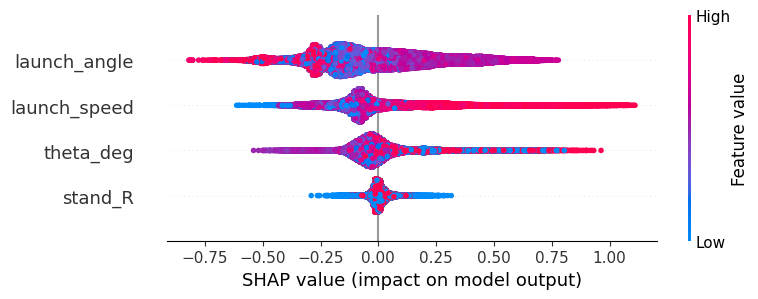

In [ ]:
shap.summary_plot(shap_values, X_spray)

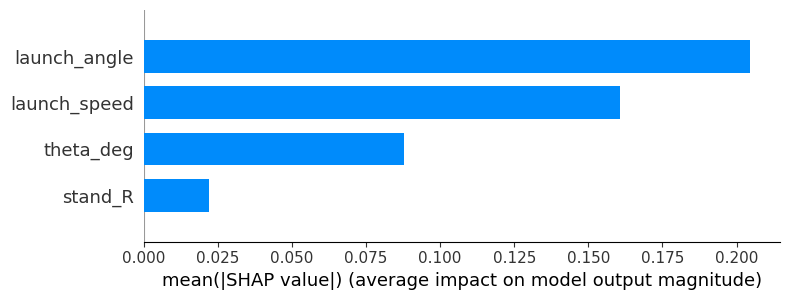

In [ ]:
shap.summary_plot(shap_values, X_spray, plot_type='bar')

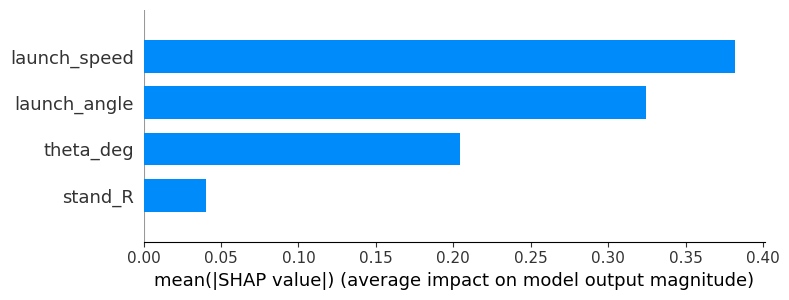

In [ ]:
shap.summary_plot(shap_values[y_spray > 1], X_spray[y_spray > 1], plot_type='bar')

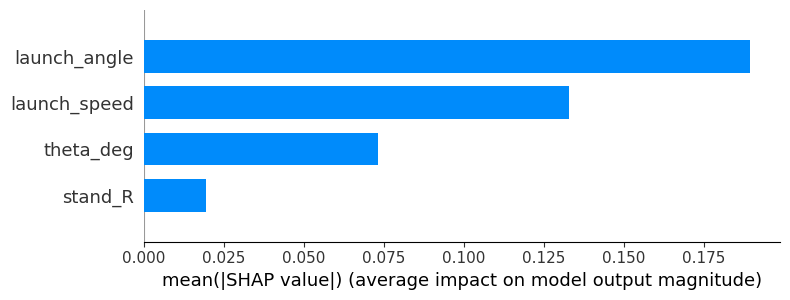

In [ ]:
shap.summary_plot(shap_values[y_spray < 1], X_spray[y_spray < 1], plot_type='bar')

In [ ]:
shap_values[y_spray < 1].mean(axis=0)

array([-0.0291399 , -0.05619774, -0.01705751,  0.00170115], dtype=float32)

In [ ]:
shap_values[y_spray < 1].std(axis=0)

array([0.16554554, 0.22302976, 0.10273937, 0.02860237], dtype=float32)

In [ ]:
leaders['sxwOBA'].sub(leaders['xwOBA']).mean()

0.007128888888888888

In [ ]:
bbe['theta_deg'].describe()

count    123729.000000
mean         42.175404
std          29.988493
min         -90.000000
25%          20.988070
50%          44.476403
75%          66.011068
max          90.000000
Name: theta_deg, dtype: float64

In [ ]:
bbe.groupby('batter_name')['woba_value'].count()

batter_name
aaron hicks              276
aaron judge              398
aaron whitefield           6
abraham almonte           23
abraham toro             263
adalberto mondesí         30
adam duvall              188
adam engel               168
adam frazier             477
adam haseley              15
adley rutschman          315
adolis garcía            426
aj pollock               394
akil baddoo              136
alan trejo                86
albert almora            167
albert pujols            258
alcides escobar           92
alec bohm                486
alec burleson             39
aledmys díaz             253
alejandro kirk           415
alejo lopez              121
alek thomas              308
alex bregman             480
alex call                 84
alex dickerson            24
alex jackson               5
alex kirilloff           110
alex verdugo             513
alfonso rivas            165
amed rosario             529
andrelton simmons         63
andrew benintendi        390
an

In [ ]:
df.loc[(df['batter_name']=='aaron judge') & (df['woba_value'].notna())].events.count()

677

In [ ]:
df.loc[(df['batter_name']=='aaron judge')].events.value_counts()

field_out                    190
strikeout                    175
walk                          92
single                        87
home_run                      62
double                        28
grounded_into_double_play     14
force_out                     11
hit_by_pitch                   6
sac_fly                        5
catcher_interf                 4
double_play                    1
fielders_choice                1
field_error                    1
Name: events, dtype: int64

In [ ]:
bbe[['woba_value', 'estimated_woba_using_speedangle', 'sxwOBA']].mean()

woba_value                         0.371283
estimated_woba_using_speedangle    0.358557
sxwOBA                             0.371275
dtype: float64

In [ ]:
df[['woba_value', 'estimated_woba_using_speedangle']].mean()

woba_value                         0.317084
estimated_woba_using_speedangle    0.358557
dtype: float64

In [ ]:
leaders.loc[leaders['PA'] > 250].sort_values('sxwOBA', ascending=False).head(5)

,batter_name,batter_id,PA,wOBA,xwOBA,sxwOBA,diff,diff %,BB%,K%,Barrels,pulled_barrels
1,aaron judge,592450,696,0.458,0.463,0.470,0.007,1.44,15.9,25.1,106.0,45.0
676,yordan alvarez,670541,561,0.427,0.462,0.432,-0.030,-6.56,13.9,18.9,78.0,29.0
16,albert pujols,405395,351,0.380,0.365,0.406,0.041,11.17,8.0,15.7,31.0,23.0
471,mike trout,545361,499,0.418,0.395,0.403,0.008,2.00,10.8,27.9,59.0,23.0
216,freddie freeman,518692,708,0.393,0.403,0.399,-0.004,-1.00,11.9,14.4,52.0,21.0


In [ ]:
leaders.loc[leaders['PA'] > 400].sort_values('xwOBA', ascending=False).head(5)

,batter_name,batter_id,PA,wOBA,xwOBA,sxwOBA,diff,diff %,BB%,K%,Barrels,pulled_barrels
1,aaron judge,592450,696,0.458,0.463,0.470,0.007,1.44,15.9,25.1,106.0,45.0
676,yordan alvarez,670541,561,0.427,0.462,0.432,-0.030,-6.56,13.9,18.9,78.0,29.0
216,freddie freeman,518692,708,0.393,0.403,0.399,-0.004,-1.00,11.9,14.4,52.0,21.0
351,juan soto,665742,664,0.376,0.401,0.391,-0.010,-2.41,20.3,14.5,53.0,23.0
471,mike trout,545361,499,0.418,0.395,0.403,0.008,2.00,10.8,27.9,59.0,23.0


In [ ]:
leaders = leaders.dropna(subset=['sxwOBA'])
from sklearn.metrics import mean_squared_error
print("rmse (xwOBA): " + str(np.sqrt(mean_squared_error(leaders['wOBA'], leaders['xwOBA']))))
print("rmse (sxwOBA): " + str(np.sqrt(mean_squared_error(leaders['wOBA'], leaders['sxwOBA']))))

rmse (xwOBA): 0.044283714923292146
rmse (sxwOBA): 0.03856037113698754


In [ ]:
from sklearn.metrics import mean_absolute_error
print("mae (xwOBA): " + str(np.sqrt(mean_absolute_error(leaders['wOBA'], leaders['xwOBA']))))
print("mae (sxwOBA): " + str(np.sqrt(mean_absolute_error(leaders['wOBA'], leaders['sxwOBA']))))

mae (xwOBA): 0.1688611088263786
mae (sxwOBA): 0.15941095273491043


In [ ]:
leaders['absolute_error_xwoba'] = np.abs(leaders['wOBA'].sub(leaders['xwOBA']))
leaders['absolute_error_sxwoba'] = np.abs(leaders['wOBA'].sub(leaders['sxwOBA']))

In [ ]:
px.scatter(data_frame=leaders.loc[leaders['PA']>300], x='absolute_error_xwoba', y='absolute_error_sxwoba', color='PA', hover_data=['batter_name'])

In [ ]:
leaders.head()

,batter_name,batter_id,PA,wOBA,xwOBA,sxwOBA,diff,diff %,BB%,K%,Barrels,pulled_barrels,absolute_error_xwoba,absolute_error_sxwoba
0,aaron hicks,543305,453,0.292,0.303,0.316,0.013,4.23,13.7,24.1,16.0,11.0,0.011,0.024
1,aaron judge,592450,696,0.458,0.463,0.470,0.007,1.44,15.9,25.1,106.0,45.0,0.005,0.012
2,aaron whitefield,664334,11,0.000,0.189,0.209,0.020,10.67,0.0,45.5,1.0,1.0,0.189,0.209
3,abraham almonte,501659,37,0.306,0.234,0.251,0.017,7.25,2.7,32.4,1.0,1.0,0.072,0.055
4,abraham toro,647351,352,0.246,0.284,0.280,-0.004,-1.52,6.3,18.5,18.0,12.0,0.038,0.034


In [ ]:
bbe['game_date'].max()

'2022-10-05'